# Osteoporosis Risk Prediction
### Comparing Machine Learning Models
This notebook will fit multiple machine learning models to determine which is best for predicting osteoporosis risk based on various lifestyle factors. This classification task will be comducted with supervised learning.

The data set is obtained from kaggle, named lifestyle-factors-influencing-osteoporosis from author Amit Kulkarni.

dataset can be downloaded with "amitvkulkarni/lifestyle-factors-influencing-osteoporosis".

In [2]:
import pandas as pd # data processing
import seaborn as sns # Plots
import matplotlib.pyplot as plt # Plots
import warnings
from sklearn.isotonic import IsotonicRegression
# Data processing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
# Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
warnings.filterwarnings("ignore")



2025-12-05 16:08:21.226975: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# First Look at the Data

In [4]:
# Data from Kaggle
df = pd.read_csv('osteoporosis_clean.csv')

# First 5 rows
df.head()


,Id,Age,Gender,Hormonal Changes,Family History,Race/Ethnicity,Body Weight,Calcium Intake,Vitamin D Intake,Physical Activity,Smoking,Alcohol Consumption,Medical Conditions,Medications,Prior Fractures,Osteoporosis
0,1734616,69.0,Female,Normal,Yes,Asian,Underweight,Low,Sufficient,Sedentary,Yes,Moderate,Rheumatoid Arthritis,Corticosteroids,Yes,1.0
1,1419098,32.0,Female,Normal,Yes,Asian,Underweight,Low,Sufficient,Sedentary,No,Moderate,Hyperthyroidism,Corticosteroids,Yes,1.0
2,1797916,89.0,Female,Postmenopausal,No,Caucasian,Normal,Adequate,Sufficient,Active,No,Moderate,Hyperthyroidism,Corticosteroids,No,1.0
3,1805337,78.0,Female,Normal,No,Caucasian,Underweight,Adequate,Insufficient,Sedentary,Yes,Moderate,Rheumatoid Arthritis,Corticosteroids,No,1.0
4,1351334,38.0,Male,Postmenopausal,Yes,African American,Normal,Low,Sufficient,Active,Yes,Moderate,Rheumatoid Arthritis,Corticosteroids,Yes,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   1958 non-null   int64  
 1   Age                  1958 non-null   float64
 2   Gender               1958 non-null   object 
 3   Hormonal Changes     1958 non-null   object 
 4   Family History       1958 non-null   object 
 5   Race/Ethnicity       1958 non-null   object 
 6   Body Weight          1958 non-null   object 
 7   Calcium Intake       1958 non-null   object 
 8   Vitamin D Intake     1958 non-null   object 
 9   Physical Activity    1958 non-null   object 
 10  Smoking              1958 non-null   object 
 11  Alcohol Consumption  1958 non-null   object 
 12  Medical Conditions   1958 non-null   object 
 13  Medications          1958 non-null   object 
 14  Prior Fractures      1958 non-null   object 
 15  Osteoporosis         1958 non-null   f

We see 16 columns and 1958 observations in the data. Our target column is `Osteoporosis` where 0 = negative and 1 = positive. The column `Patient Id` is a non-predictive feature that can be excluded from our calcuations.

We see no missing values, but not many insights to the categorical variable leading those metrics to be `NaN`.  

## Anonymity
We seperate the Patient ID from the patient features to conserve identity. Patient Id's are preserved if we need to trace the results back to paitents later on.

In [7]:
# Conserve Patient Id's
Patient_ID = df["Id"]
# Drop Id
df = df.drop(columns = ('Id'))
df.head()

,Age,Gender,Hormonal Changes,Family History,Race/Ethnicity,Body Weight,Calcium Intake,Vitamin D Intake,Physical Activity,Smoking,Alcohol Consumption,Medical Conditions,Medications,Prior Fractures,Osteoporosis
0,69.0,Female,Normal,Yes,Asian,Underweight,Low,Sufficient,Sedentary,Yes,Moderate,Rheumatoid Arthritis,Corticosteroids,Yes,1.0
1,32.0,Female,Normal,Yes,Asian,Underweight,Low,Sufficient,Sedentary,No,Moderate,Hyperthyroidism,Corticosteroids,Yes,1.0
2,89.0,Female,Postmenopausal,No,Caucasian,Normal,Adequate,Sufficient,Active,No,Moderate,Hyperthyroidism,Corticosteroids,No,1.0
3,78.0,Female,Normal,No,Caucasian,Underweight,Adequate,Insufficient,Sedentary,Yes,Moderate,Rheumatoid Arthritis,Corticosteroids,No,1.0
4,38.0,Male,Postmenopausal,Yes,African American,Normal,Low,Sufficient,Active,Yes,Moderate,Rheumatoid Arthritis,Corticosteroids,Yes,1.0


We can now see that the `Patient Id` column is no longer included.

# Exploratory Data Analysis

In [10]:
df.describe(include='all')

,Age,Gender,Hormonal Changes,Family History,Race/Ethnicity,Body Weight,Calcium Intake,Vitamin D Intake,Physical Activity,Smoking,Alcohol Consumption,Medical Conditions,Medications,Prior Fractures,Osteoporosis
count,1958.000000,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958,1958.000000
unique,NaN,2,2,2,3,2,2,2,2,2,1,2,1,2,NaN
top,NaN,Male,Normal,No,African American,Normal,Low,Sufficient,Active,Yes,Moderate,Hyperthyroidism,Corticosteroids,Yes,NaN
freq,NaN,992,981,998,681,1027,1004,1011,1021,982,1958,1325,1958,983,NaN
mean,39.101124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000
std,21.355424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500128
min,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000
75%,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Of the predictive features, our only numeric column is *Age*. There we see that 50% of our patients are under 32 years old, with the mean being 39 years old. Suggesting that the age has a right handed skew and represents younger paients best.  
All of our categorical features have two to three levels that will later have to be label encoded. We will also plot to categorical vairables to understand the bias/distribution of levels.


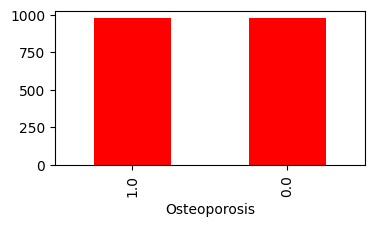

In [12]:
# Distribution of Target Variable
plt.figure(figsize = (4,2))
df['Osteoporosis'].value_counts().plot(kind = 'bar', color = 'red')
plt.show()

There is a balanced representation between patients who do and do not have osteoporosis.
No additional resampling will have to occur based on target.

In [14]:
# Designate categorical and numeric features
features_num = df['Age']
features_cat = df.drop(columns=('Age'))

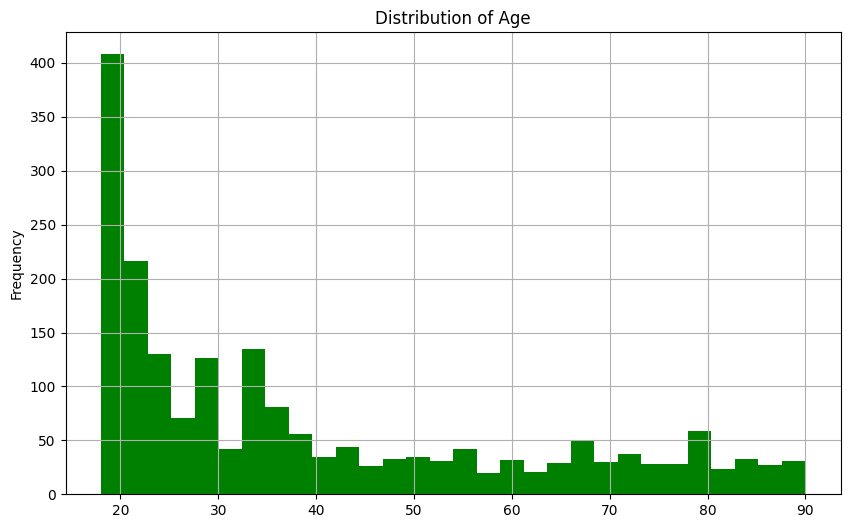

In [15]:
# Plot Numeric Features
plt.figure(figsize = (10,6))
features_num.plot(kind = "hist", bins = 30, color = "green")
plt.title("Distribution of Age")
plt.grid()
plt.show()


As mentioned above, our paitents are most represented at or below the age of 40. After 40 years old, we see a lower but consistent representation. Every age has representation.

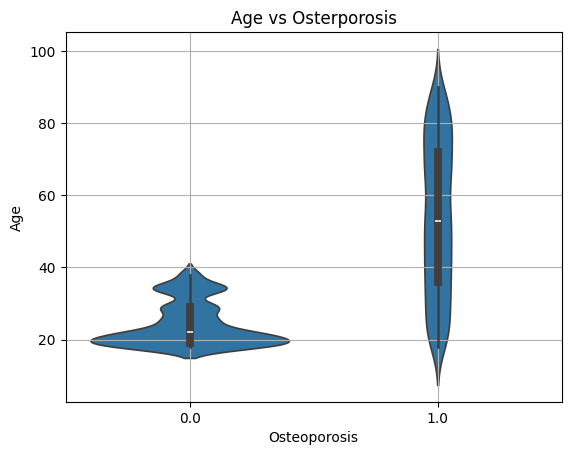

In [17]:
# Age vs Osteoporosis Risk
sns.violinplot(data = df, x = df['Osteoporosis'], y=df['Age'])
plt.title("Age vs Osterporosis")
plt.grid()
plt.show()


The violin plot illistrates the distribution of agges based on the presence of osteoporosis. The blue group, representing patients without osteoporosis, is entirely under the age of 45. This lack of representation among older healthy individuals may increase the risk of misclassifying them as have osteoporsis, creating a bias towards false positives.  
In contrast, the orange group represents patients with osteoporosis and evenly distributed across all ages.


In [19]:
df = df.fillna("None")

To ensure proper encoding for categorical levels, we will replace that NaN with "None". Sugessting the the lack of a response is condusive to them not having that lifestyle trait. For example, an `NaN` for `Alcohol Consumption` or `Medical Condition` would mean they do not drink and do not have a condition they are aware of. These will be imputed with "None".

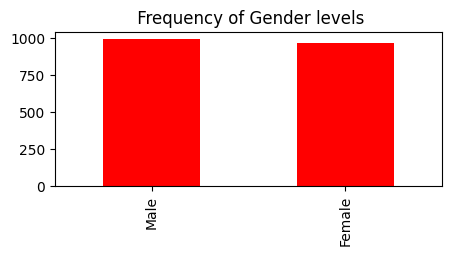

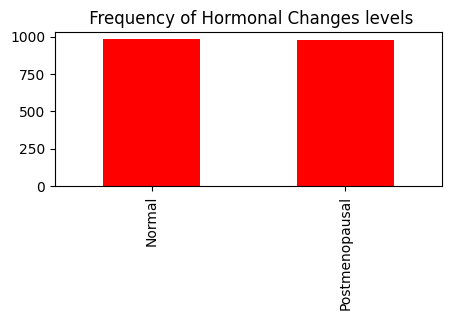

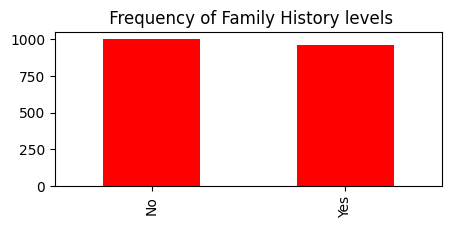

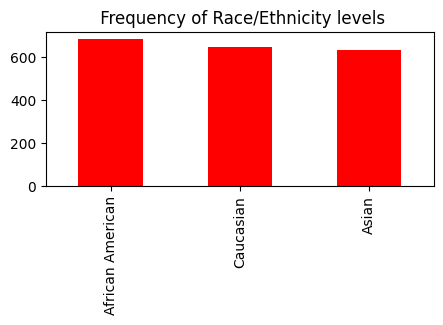

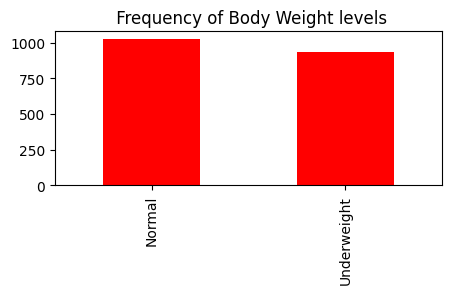

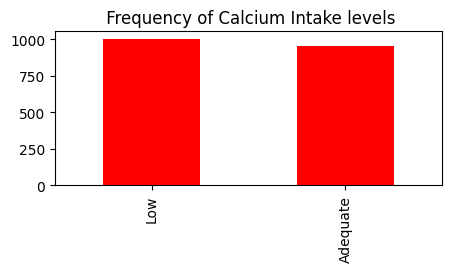

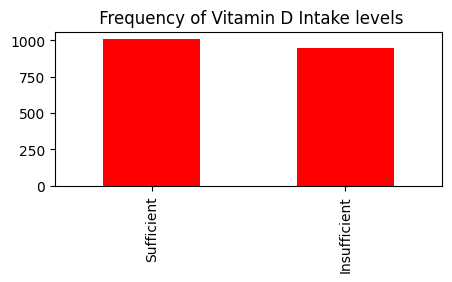

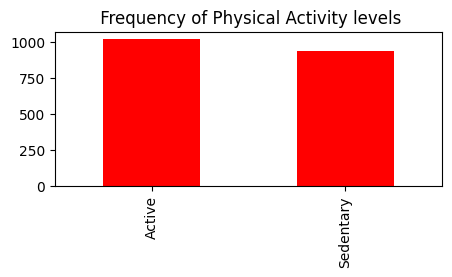

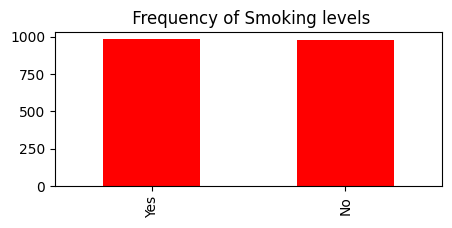

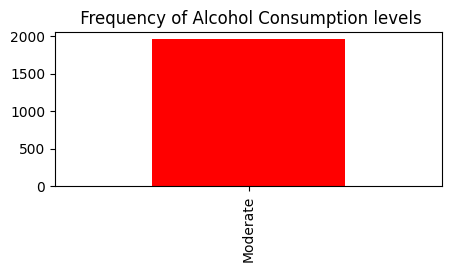

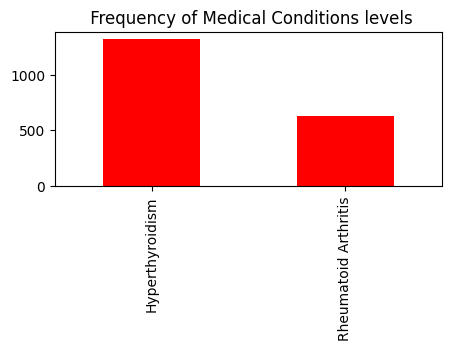

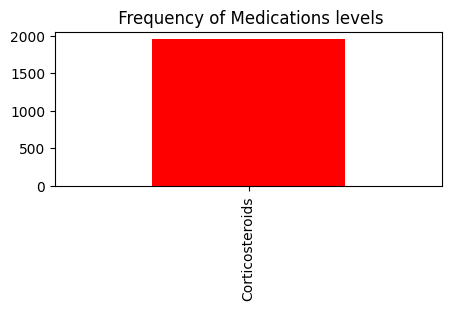

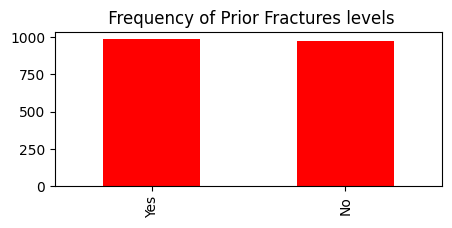

In [21]:
# Categorical variable plots
for feature in features_cat.drop(columns = "Osteoporosis"):
    plt.figure(figsize=(5,2))
    df[feature].value_counts().plot(kind='bar', color='red')
    plt.title(f" Frequency of {feature} levels")
    plt.xlabel("")

All categorical variables have fairly even representation.

# Train and Test Sets

In [24]:
# Label encoding for categorical variables
le_dict = {}
for col in features_cat:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le


In [25]:
# Split data into train & test sets
df_train, df_test = train_test_split(df, test_size= 0.2, random_state=24)
# Save labels and features seperately
train_labels = df_train['Osteoporosis']
train_features = df_train.drop(columns = ('Osteoporosis'))
# Repeat for test set
test_labels = df_test['Osteoporosis']
test_features = df_test.drop(columns = ('Osteoporosis'))

In [26]:
# Models to compare
models = {
    "Logistic Regression" : LogisticRegression(max_iter=1000),
    "Decision Tree" : DecisionTreeClassifier(random_state = 24),
    "Random Forest" : RandomForestClassifier(random_state = 24),
    "Gradient Boosting" : GradientBoostingClassifier(random_state = 24),
    "SVM" : SVC(),
    "XGBoost" : XGBClassifier(random_state = 24),
    "DNN" : Sequential([
        Dense(32, activation='relu', input_shape=(train_features.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
}

In [27]:
# Results of each model trained to train set
results = []
for model_name, model in models.items():
    if isinstance(model, Sequential):  # Check if the model is a Keras Sequential model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compile the model
        model.fit(train_features, train_labels, epochs=20, verbose=0) # Train the DNN
        _, acc = model.evaluate(test_features, test_labels, verbose=0) # Evaluate the DNN
        acc *= 100
    else:
        model.fit(train_features, train_labels)
        y_preds = model.predict(test_features)
        acc = accuracy_score(test_labels, y_preds) * 100
    results.append([model_name, round(acc, 2)])

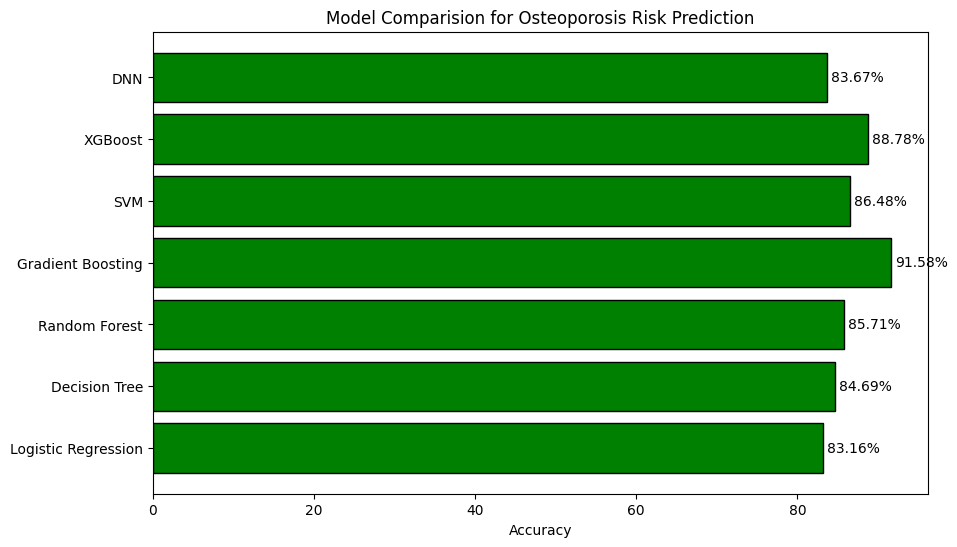

In [28]:
# Disply the results of model predictions based on Accuracy
results_df = pd.DataFrame(results, columns = ['Algorithm', 'Accuracy(%)'])

plt.figure(figsize=(10,6))
plt.barh(results_df['Algorithm'], results_df['Accuracy(%)'], color = 'green', edgecolor='black')
plt.xlabel('Accuracy')
plt.title('Model Comparision for Osteoporosis Risk Prediction')
for index, value in enumerate(results_df['Accuracy(%)']):
    plt.text(value + 0.5, index, f"{value:.2f}%", va = 'center')
plt.show()

In [29]:
#PERFORMANCE METRICS TABLE FOR ALL MODELS

metric_results = []

for model_name, model in models.items():

    # Fit model
    if isinstance(model, Sequential):  # Keras DNN
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(train_features, train_labels, epochs=20, verbose=0)
        preds = model.predict(test_features).ravel()
        pred_labels = (preds >= 0.5).astype(int)
    else:  # Sklearn models
        model.fit(train_features, train_labels)
        pred_labels = model.predict(test_features)

        # Some models (e.g., SVM without probability=True) may not support predict_proba
        try:
            preds = model.predict_proba(test_features)[:, 1]
        except:
            # If predict_proba is unavailable, fall back to decision_function, scaled to [0,1]
            try:
                decision_vals = model.decision_function(test_features)
                preds = (decision_vals - decision_vals.min()) / (decision_vals.max() - decision_vals.min())
            except:
                preds = pred_labels  # worst-case fallback

    # Compute metrics
    accuracy = accuracy_score(test_labels, pred_labels)
    precision = precision_score(test_labels, pred_labels)
    recall = recall_score(test_labels, pred_labels)
    f1 = f1_score(test_labels, pred_labels)
    auc = roc_auc_score(test_labels, preds)

    metric_results.append([
        model_name,
        round(accuracy,4),
        round(precision,4),
        round(recall,4),
        round(f1,4),
        round(auc,4)
    ])

# Convert to DataFrame for display
metrics_df = pd.DataFrame(metric_results, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"
])

metrics_df.style.background_gradient(cmap="Blues")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.831600,0.842900,0.817300,0.829900,0.913900
1,Decision Tree,0.846900,0.818600,0.893400,0.854400,0.846700
2,Random Forest,0.857100,0.937900,0.766500,0.843600,0.900600
3,Gradient Boosting,0.915800,1.000000,0.832500,0.908600,0.927600
4,SVM,0.864800,0.955700,0.766500,0.850700,0.905600
5,XGBoost,0.887800,0.932200,0.837600,0.882400,0.921300
6,DNN,0.846900,0.851300,0.842600,0.846900,0.908900


 Accuracy of Gradient Boosting Model is: 91.58


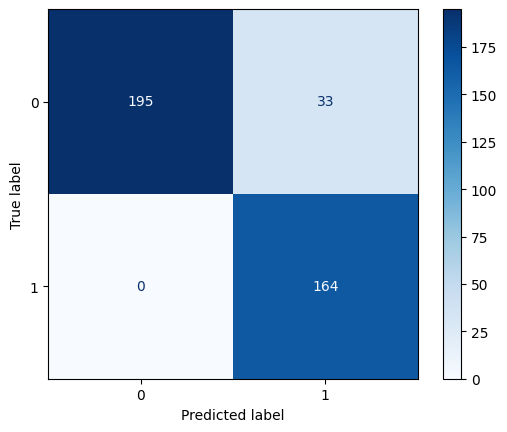

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       195
           1       1.00      0.83      0.91       197

    accuracy                           0.92       392
   macro avg       0.93      0.92      0.92       392
weighted avg       0.93      0.92      0.92       392



In [30]:
# Gradient Boosting Baseline
GBM_model = GradientBoostingClassifier(random_state = 24)
GBM_model.fit(train_features, train_labels)
GBM_preds = GBM_model.predict(test_features)
acc = accuracy_score(test_labels, GBM_preds) * 100
print(f" Accuracy of Gradient Boosting Model is: {round(acc, 2)}")

# Confusion matrix
cm = confusion_matrix(GBM_preds, test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = GBM_model.classes_)
disp.plot(cmap = "Blues")
plt.show()

# F1 score, precision, recall, support
print(classification_report(test_labels, GBM_preds))


The model acheived an accuracy of 91.58%, with 33 patients misclassified as false positives. This was expected as mentioned above, our data is missing information on healthy older individuals. This is likely causing our bias in the results and if we
Notably, the model did not miss any true positives, meaning it successfully identified all paitents with osteoporosis. Although there is a slight bias towards flase positives, this trade-off is acceptable since no cases of osteoporosis are overlooked. Given the avialable data, the model reliably ensures that every patient with osteoporosis is correctly  identified.

In [32]:
# Convert predictions to series
GBM_preds_series = pd.Series(GBM_preds, index=test_features.index)

# Create a DataFrame with actual vs predicted
results = pd.DataFrame({
    "Actual": test_labels,
    "Predicted": GBM_preds_series
})

# Filter misclassified observations
misclassified = results[results["Actual"] != results["Predicted"]]

# original features for inspection:
misclassified_with_features = test_features.loc[misclassified.index].copy()
misclassified_with_features["Actual"] = misclassified["Actual"]
misclassified_with_features["Predicted"] = misclassified["Predicted"]

print(misclassified_with_features.describe())

             Age     Gender  Hormonal Changes  Family History  Race/Ethnicity  \
count  33.000000  33.000000         33.000000       33.000000           33.00   
mean   26.454545   0.515152          0.363636        0.575758            1.00   
std     7.062626   0.507519          0.488504        0.501890            0.75   
min    18.000000   0.000000          0.000000        0.000000            0.00   
25%    21.000000   0.000000          0.000000        0.000000            0.00   
50%    25.000000   1.000000          0.000000        1.000000            1.00   
75%    34.000000   1.000000          1.000000        1.000000            2.00   
max    38.000000   1.000000          1.000000        1.000000            2.00   

       Body Weight  Calcium Intake  Vitamin D Intake  Physical Activity  \
count    33.000000       33.000000         33.000000          33.000000   
mean      0.363636        0.454545          0.727273           0.545455   
std       0.488504        0.505650          0

In [33]:
ir = IsotonicRegression(out_of_bounds='clip')
gbm_probs = GBM_model.predict_proba(test_features)[:, 1]
calibrated_probs = ir.fit_transform(gbm_probs, test_labels)

## Generate calibration plot




**Reasoning**:
Generate a calibration plot using the calibrated probabilities to visualize the improvement in calibration.



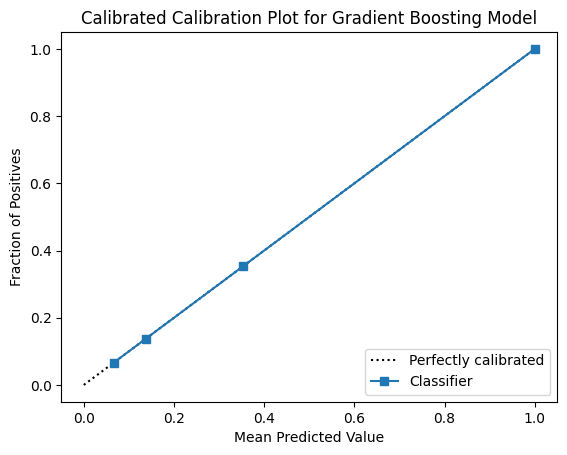

In [36]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_predictions(test_labels, calibrated_probs, n_bins=10, strategy='uniform', ax=plt.gca())
disp.ax_.set_title('Calibrated Calibration Plot for Gradient Boosting Model')
disp.ax_.set_xlabel('Mean Predicted Value')
disp.ax_.set_ylabel('Fraction of Positives')
plt.show()

**Reasoning**:
Add a markdown cell to interpret the new calibration plot and discuss the effect of isotonic regression on the model's calibration.



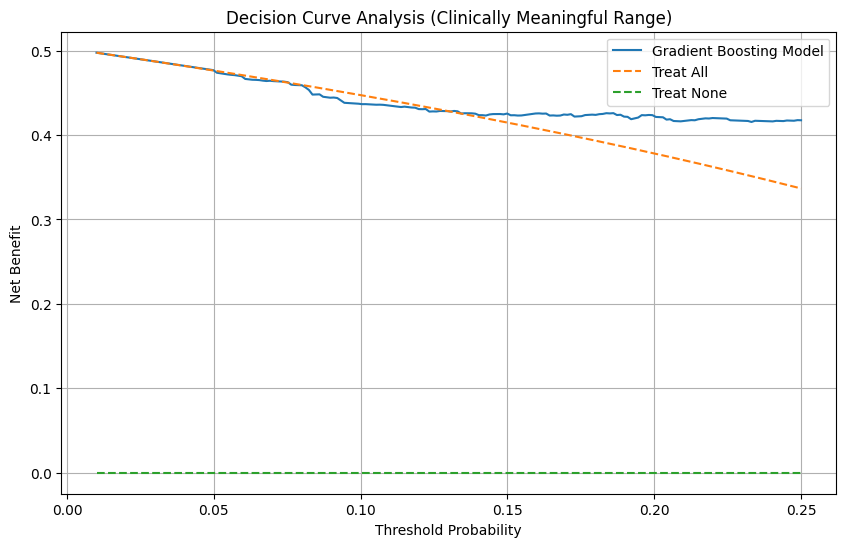

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def net_benefit_model(probabilities, labels, threshold):
    pred_pos = probabilities >= threshold
    TP = np.sum((pred_pos) & (labels == 1))
    FP = np.sum((pred_pos) & (labels == 0))
    N = len(labels)
    return (TP/N) - (FP/N) * (threshold/(1-threshold))

def net_benefit_treat_all(labels, threshold):
    prevalence = np.mean(labels)
    return prevalence - (1 - prevalence) * (threshold/(1-threshold))

# Get prevalence
prevalence = np.mean(test_labels)

# Clinically meaningful threshold range: 0 to 2×prevalence
upper = min(0.25, prevalence * 2)
thresholds = np.linspace(0.01, upper, 200)

nb_model = [net_benefit_model(gbm_probs, test_labels, t) for t in thresholds]
nb_all = [net_benefit_treat_all(test_labels, t) for t in thresholds]
nb_none = np.zeros_like(thresholds)

plt.figure(figsize=(10,6))
plt.plot(thresholds, nb_model, label="Gradient Boosting Model")
plt.plot(thresholds, nb_all, '--', label="Treat All")
plt.plot(thresholds, nb_none, '--', label="Treat None")

plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (Clinically Meaningful Range)")
plt.legend()
plt.grid(True)
plt.show()


## Explainable AI with SHAP

To better understand *why* the Gradient Boosting model predicts high or low osteoporosis risk,
we use **SHAP (SHapley Additive exPlanations)**. SHAP provides:

- **Global explanations**: which features are most important overall across the test set.
- **Local explanations**: how individual features push a single patient's predicted risk up or down.

Below, we first compute SHAP values for the Gradient Boosting model, then visualize global and local explanations.


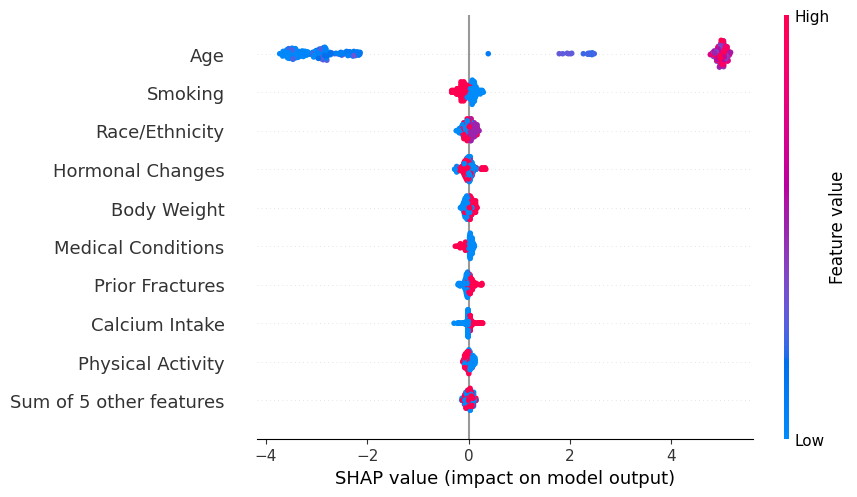

In [40]:
# If SHAP is not installed in this environment, uncomment and run the line below once:
# !pip install shap

import shap

# Create a SHAP explainer for the trained Gradient Boosting model
# Using the training data as the background dataset
explainer = shap.Explainer(GBM_model, train_features)

# Compute SHAP values for the test set
shap_values = explainer(test_features)

# 1. Global feature importance: beeswarm plot
shap.plots.beeswarm(shap_values, max_display=10)

Selected patient index: 0


,Age,Gender,Hormonal Changes,Family History,Race/Ethnicity,Body Weight,Calcium Intake,Vitamin D Intake,Physical Activity,Smoking,Alcohol Consumption,Medical Conditions,Medications,Prior Fractures
1496,34.0,1,0,1,2,0,0,1,1,1,0,0,0,1


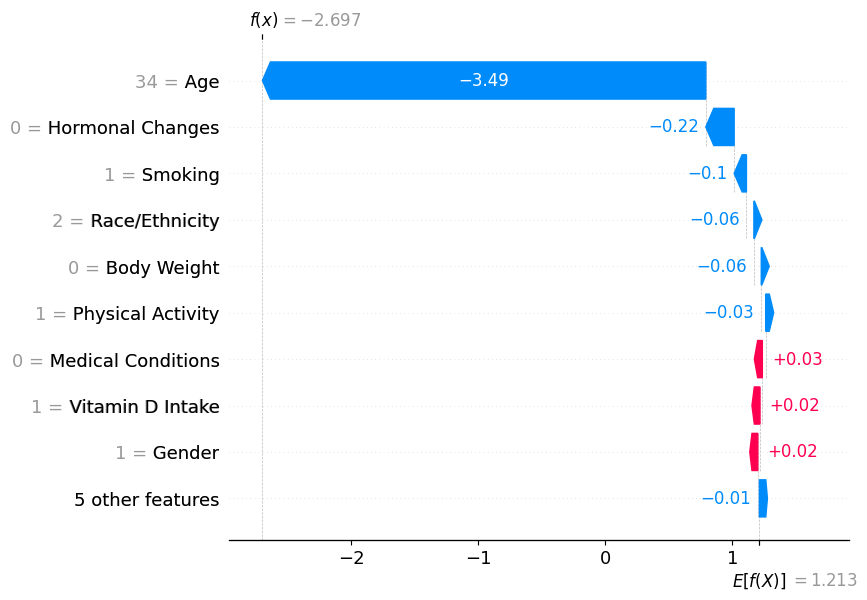

In [41]:
# 2. Local explanation for an individual patient

# Choose an index from the test set (change this to inspect other patients)
patient_index = 0

patient_data = test_features.iloc[[patient_index]]
patient_shap = shap_values[patient_index]

print("Selected patient index:", patient_index)
display(patient_data)

# Waterfall plot: contribution of each feature to this patient's predicted risk
shap.plots.waterfall(patient_shap, max_display=10)

### Interpretation of SHAP Plots

- The **global beeswarm plot** ranks features by their overall impact on model predictions.
  Features toward the top are most influential for osteoporosis risk in this dataset.
- The **local waterfall plot** shows, for one selected patient, how each feature value
  increases (red bars) or decreases (blue bars) the predicted risk relative to the model's baseline.

These explainable AI visualizations help clinicians understand and trust the Gradient Boosting model by
linking predictions back to clinically meaningful risk factors.
